# Simulations modèle ICSV

In [1]:
import vocal_tract_constrained as vc
from body_vocal_tract import *
from terminal_impedance import *

import pyphs as phs
import sympy as sy
import numpy as np
import os
#from utils import signal_generator
#from utils import functions
#from utils.glottal_signal_generator import glottal_signal
#from utils.signal_generator import simple_mouth_opening
#from utils.signal_generator import mouth_opening_and_glottal
#from utils.timer import Timer as Timer
import datetime
import pickle
import sympy as sy
import matplotlib.pyplot as plt
from scipy.io.wavfile import write as wavWrite
import h5py
sy.init_printing()

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

PPTY_PHY_PARAMS = {"positive": True, "real" : True }                            
PPTY_STATE_VAR  = {"real" : True }

In [2]:
import time
import datetime
class Timer(object):
    """ 
    Allows one to time a particular set of actions.
    
    Example:
    ```(Python)
        with Timer('foo_stuff'):
           # do some foo
           # do some stuff
    ```
    
    Credit: Eli Bendersky
    https://stackoverflow.com/questions/5849800/what-is-the-python-equivalent-of-matlabs-tic-and-toc-functions
    """
    def __init__(self, name=None):
        self.name = name

    def __enter__(self):
        self.tstart = time.time()
        currentDT = datetime.datetime.now()
        print('Start: ' + str(currentDT))

    def __exit__(self, type, value, traceback):
        if self.name:
            print('[%s]' % self.name,)
        print('Elapsed: {:4.2f} sec'.format(time.time() - self.tstart))

In [3]:
phs.__version__
IMPULSE_RESPONSE = True

## Instanciation de l'objet `core`
On considère que la largeur $L$ est égale à la hauteur au repos $h_0$ pour un tronçon donné.

Pour la voyelle A, on prend $A_1 = \frac{1}{10} A_2$ avec $A_i$ l'aire de la section du tronçon $i=1,2$.

In [4]:
N_tube       = 4
label        = 'vocal_tract'
forme_model  = 'quad_comp_shift'
total_length = 0.175

h = 0.02 
L = h


h_ray = 0.08
Sray = (h_ray)**2

VT_subs = {
        'P_0'       : 101.325e03,
        'rho_0'     : 1.225,
        'gamma'     : 1.4,
        'Z_ray'     : 128/(9*Sray),
        }

# Calcul des V0
for i in range(N_tube): # V = 2 * ell * L * h
    ind = str(i+1)
    VT_subs["ell_" + ind] = total_length/(2*N_tube)
    VT_subs["L_" + ind]   = L
    Sw                    = 2*VT_subs['ell_' + ind]*L
    VT_subs["V_0_" + ind] = Sw*h
    print("V_0_{0} : {1}".format(i+1, VT_subs["V_0_" + ind]))

# Assemblage des dictionnaires
VT_subs_tot = dict(VT_subs)

core = vc.VocalTractLumpedParameter(
                                    N     = N_tube,
                                    label = label,
                                    **VT_subs_tot,
                                    )

assert not core.freesymbols(), 'Il manque des valeurs/échelles'

V_0_1 : 1.75e-05
V_0_2 : 1.75e-05
V_0_3 : 1.75e-05
V_0_4 : 1.75e-05
Computing equations pour N = 4...
Done !


In [5]:
# ajout de ressort dans la paroi
body = []
    
for i in range(N_tube):
    body.append(DissipativeSingleSpringBody(n=i+1))
    core = core +  body[i]
    core.add_connector((2, core.y.index(body[i].y[0])), alpha=-1)
    

# ajout d'une impédance de rayonnement
composant_impedance = RadiationImpedance()
core = core + composant_impedance
core.add_connector((1, core.y.index(composant_impedance.y[0])), alpha=1)


core.connect()

In [6]:
## Update subs
body_subs = {}

for i in range(1,N_tube+1):    
    body_subs['k_' + str(i)] = 845
    body_subs['r_' + str(i)] = 0.8

core.subs.update(                                                       
    {core.symbols(k,**PPTY_PHY_PARAMS): v for k, v in body_subs.items()}   
)

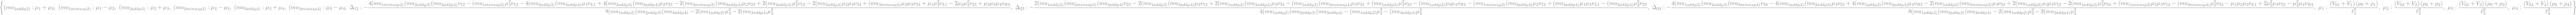

In [7]:
core.observers

## Configuration de la simulation

In [8]:
config = {'fs'   : 1e5, # sample rate (Hz)
          'path' : os.path.join(os.getcwd(), '03_data'), # folder for output results/build
          'lang' : 'python',
          'cmake': r'cmake',
          'grad' : 'discret',
          'maxit': 20,
          'pbar' : False,
          'split': False,
          'timer': True,
          'epsdg': np.power(np.finfo(np.float64).eps, 0.4),
          'eps'  : np.finfo(np.float64).eps,
         }
print(np.finfo(np.float64).eps)


with Timer('Building method'):
    simu = core.to_simulation(
                              config, 
                              erase = True,
                             )

2.220446049250313e-16
Start: 2020-04-24 16:46:34.910598
Build method vocal_tract...
Build numeric vocal_tract...


<lambdifygenerated-1>:2: RuntimeWarning: invalid value encountered in double_scalars
  return ([2089.79591836735*(V_1 + 1.75e-5)*(rho_1 + 1.225), 2089.79591836735*(V_2 + 1.75e-5)*(rho_2 + 1.225), mu_1 + mu_2, 2089.79591836735*(V_3 + 1.75e-5)*(rho_3 + 1.225), mu_2 + mu_3, 2089.79591836735*(V_4 + 1.75e-5)*(rho_4 + 1.225), mu_3 + mu_4, mu_1 - mu_2, mu_2 - mu_3, mu_3 - mu_4, -(_Dummy_166*mu_2*mu_3*nu_34 - 2*_Dummy_167*_Dummy_168*mu_2*nu_23 + 4*_Dummy_167*_Dummy_169*_Dummy_170*nu_12 - 4*_Dummy_167*_Dummy_169*mu_1*nu_L1 + 4*_Dummy_167*_Dummy_169*mu_2*nu_23 + 2*_Dummy_167*mu_2**2*nu_12 - 2*_Dummy_167*mu_2*mu_3*nu_34 - _Dummy_170*mu_3**2*nu_12 + mu_1*mu_3**2*nu_L1 - 2*mu_2*mu_3**2*nu_23 + mu_2*mu_3*mu_4*nu_R4)/(8*_Dummy_167*_Dummy_169*_Dummy_171 - 2*_Dummy_167*mu_2**2 - 2*_Dummy_171*mu_3**2), -(-_Dummy_166*_Dummy_171*mu_3*nu_34 + 2*_Dummy_167*_Dummy_168*_Dummy_171*nu_23 - _Dummy_167*_Dummy_170*mu_2*nu_12 - 2*_Dummy_167*_Dummy_171*mu_2*nu_12 + 2*_Dummy_167*_Dummy_171*mu_3*nu_34 + _Dummy_167*mu_

<lambdifygenerated-3>:2: RuntimeWarning: invalid value encountered in double_scalars
  return (array([[100000.0, 0, 0, 0, 0, Pi_y1*select([less(dPi_y1, -5.4774205922939e-7),less(dPi_y1, 5.4774205922939e-7),True], [(3*Pi_y1 + 3*dPi_y1)/(dPi_y1*(V_1 + 1.75e-5)*(rho_1 + 1.225)) - (-3/2*Pi_y1**2/((V_1 + 1.75e-5)*(rho_1 + 1.225)) + (3/2)*(Pi_y1 + dPi_y1)**2/((V_1 + 1.75e-5)*(rho_1 + 1.225)))/dPi_y1**2,1.5/((V_1 + 1.75e-5)*(rho_1 + 1.225)),(3*Pi_y1 + 3*dPi_y1)/(dPi_y1*(V_1 + 1.75e-5)*(rho_1 + 1.225)) - (-3/2*Pi_y1**2/((V_1 + 1.75e-5)*(rho_1 + 1.225)) + (3/2)*(Pi_y1 + dPi_y1)**2/((V_1 + 1.75e-5)*(rho_1 + 1.225)))/dPi_y1**2], default=nan)/((V_1 + 1.75e-5)*(rho_1 + 1.225)), 0, 0, 0, 0, 0, 0, 0, select([less(drho_1, -5.4774205922939e-7),less(drho_1, 5.4774205922939e-7),True], [(-0.999583506872137*Pi_y1**2/((V_1 + 1.75e-5)*(0.816326530612245*drho_1 + 0.816326530612245*rho_1 + 1)**2) + 47265.306122449*(V_1 + 1.75e-5)*(2*drho_1 + 2*rho_1) + 2089.79591836735*(V_1 + 1.75e-5)*(nu_L1*(-1/2*Delta_12 - 1

<lambdifygenerated-4>:2: RuntimeWarning: invalid value encountered in double_scalars
  return ([select([less(dnu_L1, -5.4774205922939e-7),less(dnu_L1, 5.4774205922939e-7),True], [(-2089.79591836735*(V_1 + 1.75e-5)*(rho_1 + 1.225)*(nu_L1*(-1/2*Delta_12 - 1/4*nu_12 + nu_L1) + (Delta_12 + (1/2)*nu_12)*(Delta_12 + (1/2)*nu_12 - 1/2*nu_L1)) + 2089.79591836735*(V_1 + 1.75e-5)*(rho_1 + 1.225)*((Delta_12 + (1/2)*nu_12)*(Delta_12 - 1/2*dnu_L1 + (1/2)*nu_12 - 1/2*nu_L1) + (dnu_L1 + nu_L1)*(-1/2*Delta_12 + dnu_L1 - 1/4*nu_12 + nu_L1)))/dnu_L1,2089.79591836735*dnu_L1*(V_1 + 1.75e-5)*(rho_1 + 1.225) + 2089.79591836735*(V_1 + 1.75e-5)*(rho_1 + 1.225)*(-Delta_12 - 1/2*nu_12 + 2*nu_L1),(-2089.79591836735*(V_1 + 1.75e-5)*(rho_1 + 1.225)*(nu_L1*(-1/2*Delta_12 - 1/4*nu_12 + nu_L1) + (Delta_12 + (1/2)*nu_12)*(Delta_12 + (1/2)*nu_12 - 1/2*nu_L1)) + 2089.79591836735*(V_1 + 1.75e-5)*(rho_1 + 1.225)*((Delta_12 + (1/2)*nu_12)*(Delta_12 - 1/2*dnu_L1 + (1/2)*nu_12 - 1/2*nu_L1) + (dnu_L1 + nu_L1)*(-1/2*Delta_12 +

Build data i/o...
[Building method]
Elapsed: 62.64 sec


<lambdifygenerated-6>:2: RuntimeWarning: invalid value encountered in double_scalars
  return ([-select([less(dnu_L1, -5.4774205922939e-7),less(dnu_L1, 5.4774205922939e-7),True], [(-2089.79591836735*(V_1 + 1.75e-5)*(rho_1 + 1.225)*(nu_L1*(-1/2*Delta_12 - 1/4*nu_12 + nu_L1) + (Delta_12 + (1/2)*nu_12)*(Delta_12 + (1/2)*nu_12 - 1/2*nu_L1)) + 2089.79591836735*(V_1 + 1.75e-5)*(rho_1 + 1.225)*((Delta_12 + (1/2)*nu_12)*(Delta_12 - 1/2*dnu_L1 + (1/2)*nu_12 - 1/2*nu_L1) + (dnu_L1 + nu_L1)*(-1/2*Delta_12 + dnu_L1 - 1/4*nu_12 + nu_L1)))/dnu_L1,2089.79591836735*dnu_L1*(V_1 + 1.75e-5)*(rho_1 + 1.225) + 2089.79591836735*(V_1 + 1.75e-5)*(rho_1 + 1.225)*(-Delta_12 - 1/2*nu_12 + 2*nu_L1),(-2089.79591836735*(V_1 + 1.75e-5)*(rho_1 + 1.225)*(nu_L1*(-1/2*Delta_12 - 1/4*nu_12 + nu_L1) + (Delta_12 + (1/2)*nu_12)*(Delta_12 + (1/2)*nu_12 - 1/2*nu_L1)) + 2089.79591836735*(V_1 + 1.75e-5)*(rho_1 + 1.225)*((Delta_12 + (1/2)*nu_12)*(Delta_12 - 1/2*dnu_L1 + (1/2)*nu_12 - 1/2*nu_L1) + (dnu_L1 + nu_L1)*(-1/2*Delta_12 

In [9]:
tmax  = 0.5
Nit   = int(tmax*config['fs'])
t_vec = np.linspace(0, tmax, Nit)

## Initialisation
Comme on a le SHP relevé, on peut initialiser tous les états à 0.

In [10]:
core.x

In [11]:
init_X = {'x' : [0.0 for i in range(len(core.x))]}

## Signaux d'entrée

In [12]:
t_imp = 0.001
ind_start = int(t_imp*config['fs'])
if IMPULSE_RESPONSE:
    u = np.zeros((Nit, len(core.u)))
    u[ind_start,0] = 1

## Simulation

In [13]:
print('Build de la simulation à {0}'.format(datetime.datetime.now()))
simu.init(
        u     = u,
        nt    = Nit,
        inits = init_X
        )
print('Simulation démarée à {0}'.format(datetime.datetime.now()))
simu.process()
print('Simulation finie à {0}'.format(datetime.datetime.now()))

Build de la simulation à 2020-04-24 16:47:37.896715
Build numeric vocal_tract...


<lambdifygenerated-7>:2: RuntimeWarning: invalid value encountered in double_scalars
  return ([2089.79591836735*(V_1 + 1.75e-5)*(rho_1 + 1.225), 2089.79591836735*(V_2 + 1.75e-5)*(rho_2 + 1.225), mu_1 + mu_2, 2089.79591836735*(V_3 + 1.75e-5)*(rho_3 + 1.225), mu_2 + mu_3, 2089.79591836735*(V_4 + 1.75e-5)*(rho_4 + 1.225), mu_3 + mu_4, mu_1 - mu_2, mu_2 - mu_3, mu_3 - mu_4, -(_Dummy_172*mu_2*mu_3*nu_34 - 2*_Dummy_173*_Dummy_174*mu_2*nu_23 + 4*_Dummy_173*_Dummy_175*_Dummy_176*nu_12 - 4*_Dummy_173*_Dummy_175*mu_1*nu_L1 + 4*_Dummy_173*_Dummy_175*mu_2*nu_23 + 2*_Dummy_173*mu_2**2*nu_12 - 2*_Dummy_173*mu_2*mu_3*nu_34 - _Dummy_176*mu_3**2*nu_12 + mu_1*mu_3**2*nu_L1 - 2*mu_2*mu_3**2*nu_23 + mu_2*mu_3*mu_4*nu_R4)/(8*_Dummy_173*_Dummy_175*_Dummy_177 - 2*_Dummy_173*mu_2**2 - 2*_Dummy_177*mu_3**2), -(-_Dummy_172*_Dummy_177*mu_3*nu_34 + 2*_Dummy_173*_Dummy_174*_Dummy_177*nu_23 - _Dummy_173*_Dummy_176*mu_2*nu_12 - 2*_Dummy_173*_Dummy_177*mu_2*nu_12 + 2*_Dummy_173*_Dummy_177*mu_3*nu_34 + _Dummy_173*mu_

<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in double_scalars
  return (array([[100000.0, 0, 0, 0, 0, Pi_y1*select([less(dPi_y1, -5.4774205922939e-7),less(dPi_y1, 5.4774205922939e-7),True], [(3*Pi_y1 + 3*dPi_y1)/(dPi_y1*(V_1 + 1.75e-5)*(rho_1 + 1.225)) - (-3/2*Pi_y1**2/((V_1 + 1.75e-5)*(rho_1 + 1.225)) + (3/2)*(Pi_y1 + dPi_y1)**2/((V_1 + 1.75e-5)*(rho_1 + 1.225)))/dPi_y1**2,1.5/((V_1 + 1.75e-5)*(rho_1 + 1.225)),(3*Pi_y1 + 3*dPi_y1)/(dPi_y1*(V_1 + 1.75e-5)*(rho_1 + 1.225)) - (-3/2*Pi_y1**2/((V_1 + 1.75e-5)*(rho_1 + 1.225)) + (3/2)*(Pi_y1 + dPi_y1)**2/((V_1 + 1.75e-5)*(rho_1 + 1.225)))/dPi_y1**2], default=nan)/((V_1 + 1.75e-5)*(rho_1 + 1.225)), 0, 0, 0, 0, 0, 0, 0, select([less(drho_1, -5.4774205922939e-7),less(drho_1, 5.4774205922939e-7),True], [(-0.999583506872137*Pi_y1**2/((V_1 + 1.75e-5)*(0.816326530612245*drho_1 + 0.816326530612245*rho_1 + 1)**2) + 47265.306122449*(V_1 + 1.75e-5)*(2*drho_1 + 2*rho_1) + 2089.79591836735*(V_1 + 1.75e-5)*(nu_L1*(-1/2*Delta_12 - 1

<lambdifygenerated-10>:2: RuntimeWarning: invalid value encountered in double_scalars
  return ([select([less(dnu_L1, -5.4774205922939e-7),less(dnu_L1, 5.4774205922939e-7),True], [(-2089.79591836735*(V_1 + 1.75e-5)*(rho_1 + 1.225)*(nu_L1*(-1/2*Delta_12 - 1/4*nu_12 + nu_L1) + (Delta_12 + (1/2)*nu_12)*(Delta_12 + (1/2)*nu_12 - 1/2*nu_L1)) + 2089.79591836735*(V_1 + 1.75e-5)*(rho_1 + 1.225)*((Delta_12 + (1/2)*nu_12)*(Delta_12 - 1/2*dnu_L1 + (1/2)*nu_12 - 1/2*nu_L1) + (dnu_L1 + nu_L1)*(-1/2*Delta_12 + dnu_L1 - 1/4*nu_12 + nu_L1)))/dnu_L1,2089.79591836735*dnu_L1*(V_1 + 1.75e-5)*(rho_1 + 1.225) + 2089.79591836735*(V_1 + 1.75e-5)*(rho_1 + 1.225)*(-Delta_12 - 1/2*nu_12 + 2*nu_L1),(-2089.79591836735*(V_1 + 1.75e-5)*(rho_1 + 1.225)*(nu_L1*(-1/2*Delta_12 - 1/4*nu_12 + nu_L1) + (Delta_12 + (1/2)*nu_12)*(Delta_12 + (1/2)*nu_12 - 1/2*nu_L1)) + 2089.79591836735*(V_1 + 1.75e-5)*(rho_1 + 1.225)*((Delta_12 + (1/2)*nu_12)*(Delta_12 - 1/2*dnu_L1 + (1/2)*nu_12 - 1/2*nu_L1) + (dnu_L1 + nu_L1)*(-1/2*Delta_12 

<lambdifygenerated-12>:2: RuntimeWarning: invalid value encountered in double_scalars
  return ([-select([less(dnu_L1, -5.4774205922939e-7),less(dnu_L1, 5.4774205922939e-7),True], [(-2089.79591836735*(V_1 + 1.75e-5)*(rho_1 + 1.225)*(nu_L1*(-1/2*Delta_12 - 1/4*nu_12 + nu_L1) + (Delta_12 + (1/2)*nu_12)*(Delta_12 + (1/2)*nu_12 - 1/2*nu_L1)) + 2089.79591836735*(V_1 + 1.75e-5)*(rho_1 + 1.225)*((Delta_12 + (1/2)*nu_12)*(Delta_12 - 1/2*dnu_L1 + (1/2)*nu_12 - 1/2*nu_L1) + (dnu_L1 + nu_L1)*(-1/2*Delta_12 + dnu_L1 - 1/4*nu_12 + nu_L1)))/dnu_L1,2089.79591836735*dnu_L1*(V_1 + 1.75e-5)*(rho_1 + 1.225) + 2089.79591836735*(V_1 + 1.75e-5)*(rho_1 + 1.225)*(-Delta_12 - 1/2*nu_12 + 2*nu_L1),(-2089.79591836735*(V_1 + 1.75e-5)*(rho_1 + 1.225)*(nu_L1*(-1/2*Delta_12 - 1/4*nu_12 + nu_L1) + (Delta_12 + (1/2)*nu_12)*(Delta_12 + (1/2)*nu_12 - 1/2*nu_L1)) + 2089.79591836735*(V_1 + 1.75e-5)*(rho_1 + 1.225)*((Delta_12 + (1/2)*nu_12)*(Delta_12 - 1/2*dnu_L1 + (1/2)*nu_12 - 1/2*nu_L1) + (dnu_L1 + nu_L1)*(-1/2*Delta_12

Build data i/o...
Write u to hdf5 file...
Write u to hdf5 file: Done.
Simulation démarée à 2020-04-24 16:48:35.597543
Simulation: Process...
Total time: 1826.617030620575s
Total time w.r.t number of time-steps: 0.0365323406124115s

Simulation: Done
Simulation finie à 2020-04-24 17:19:02.215197


## Données

In [14]:
expr_obs = []
lab_obs = []
subs = {}

# On récupère les observateurs et leurs expressions
for key, val in core.observers.items():
    subs[key] = val.subs(core.subs)
    lab_obs.append(key)
    expr_obs.append(val.subs(subs).subs(core.subs))
    
# On créé les fonctions numpy
f_obs = []
for expr in expr_obs:
    f_obs.append(sy.lambdify(core.x, expr))
    
# On évalue les fonctions
data_obs = []
for func in f_obs:
    data_obs.append(func(*simu.data.x().T))
    
# Formattage numpy
data_obs = np.array(data_obs).T

<IPython.core.display.Javascript object>


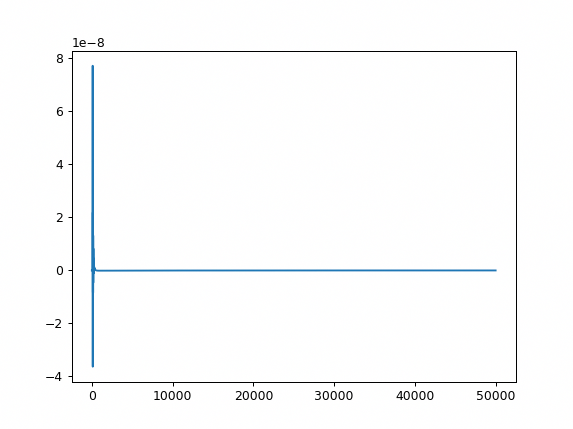

In [15]:
%matplotlib nbagg
plt.figure()
plt.plot(data_obs[:,7])

In [16]:
# Date, heure etc...
timedate_now = datetime.datetime.now()
month  = timedate_now.month
day    = timedate_now.day
hour   = timedate_now.hour
minute = timedate_now.minute
date_now = [str(month).zfill(2), str(day).zfill(2), str(hour).zfill(2), str(minute).zfill(2)]

filename = '03_data/simu.{0}_{1}.{2}_{3}.h5'.format(*date_now)
fid      = h5py.File(filename, 'x')
dt       = h5py.string_dtype()

# Creating groups
data_simu     = fid.create_group('data_simu')
metadata      = fid.create_group('metadata')
model         = fid.create_group('model')
fid.flush()

# Saving signals
data = np.array( list(simu.data.u())     , dtype=np.float64).squeeze()
data_simu.create_dataset("u", data=data)

data = np.array( list(simu.data.y())     , dtype=np.float64).squeeze()
data_simu.create_dataset("y", data=data)

data = np.array( list(simu.data.x())     , dtype=np.float64).squeeze()
data_simu.create_dataset("x", data=data)

data = np.array( list(data_obs)     , dtype=np.float64).squeeze()
data_simu.create_dataset("o", data=data)

data = np.array( list(simu.data.dx())    , dtype=np.float64).squeeze()
data_simu.create_dataset("dx", data=data)

data = np.array( list(simu.data.dxH())   , dtype=np.float64).squeeze()
data_simu.create_dataset("dxH", data=data)

data = np.array( list(simu.data.dtx())   , dtype=np.float64).squeeze()
data_simu.create_dataset("dtx", data=data)

data = np.array( list(simu.data.w())   , dtype=np.float64).squeeze()
data_simu.create_dataset("w", data=data)
data = np.array( list(simu.data.z())   , dtype=np.float64).squeeze()
data_simu.create_dataset("z", data=data)

# time vector
data = t_vec
data_simu.create_dataset("t", data=data)

data

data = init_X['x']
data_simu.create_dataset("init_X", data=data)

#### données sur le modèle
model.create_dataset(name="N_tube", shape=(1,),data=N_tube)
model.create_dataset(name="forme model", data=str(forme_model))

subs = VT_subs
place = model.create_group("VT_subs")

for key, val in subs.items():
    place.create_dataset(name=key, data=val)

subs = body_subs
place = model.create_group("body_subs")
for key, val in subs.items():
    place.create_dataset(name=key, data=val)
    
# labels
str_x_label = []
str_u_label = []
str_y_label = []
str_o_label = []
str_w_label = []

Nx = len(core.x)
Nw = len(core.w)
Nu = len(core.u)
model.create_dataset("Nw", (1,), data=Nw)
model.create_dataset("Nx", (1,), data=Nx)
model.create_dataset("Nu", (1,), data=Nu)

for label in core.x:
    str_x_label.append(str(label).encode('ascii'))
for label in core.w:
    str_w_label.append(str(label))
for label in core.u:
    str_u_label.append(str(label))
for label in core.y:
    str_y_label.append(str(label))
for label in core.o():
    str_o_label.append(str(label))

data = np.array(str_x_label, dtype='S')
model.create_dataset("x_label", shape=data.shape, data=data, dtype=dt)

data = np.array(str_o_label, dtype='S')
model.create_dataset("o_label", shape=data.shape, data=data, dtype=dt)

data = np.array(str_w_label, dtype='S')
model.create_dataset("w_label", shape=data.shape, data=data, dtype=dt)

data = np.array(str_y_label, dtype='S')
model.create_dataset("y_label", shape=data.shape, data=data, dtype=dt)

data = np.array(str_u_label, dtype='S')
model.create_dataset("u_label", shape=data.shape, data=data, dtype=dt)


### Config de la simu
subs = config
metadata.create_dataset("config",(1,),data=str(subs), dtype=dt)

data = phs.__version__
metadata.create_dataset("pyphs_version",(1,),data=str(data), dtype=dt)

data = Nit
metadata.create_dataset("Nit", data=data)



data = date_now
for i, el in enumerate(data):
    data[i] = int(el)
metadata.create_dataset("date_now", data=data)

fid.flush()
fid.close()
%store filename

Stored 'filename' (str)


In [17]:
#%run ./01_GRAPHS_tube_uniforme.ipynb